In [93]:
#data manipulation
import numpy as np
import pandas as pd
pd.option_context('display.max_rows', None, 'display.max_columns', None)
import nltk
from nltk.tokenize import word_tokenize

#stats/ml
import scipy
import sklearn as sk
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

#vis
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

#additional support packages
from datetime import date, datetime, timedelta
import random
import re
import joblib #save models
import shap #feature importance explainability

# import logging #create and update logger files
# logging.basicConfig(filename='..\models\logs\performance.log',)

# Model Class Components
1. Choose Model
    -Logistic Regression
    -XGBoost
2. K-Fold Cross Validation
3. Hyperparameter Optimization
4. Evaluation
5. Visualize Results
6. Save Model, Log results

In [74]:
class ModelTrainer():
    '''Class for training models for Austin Animal Center data
    
    Inputs
    ===========
    model: str
        chooses model to load. Only accepts "log" and "xgb" as inputs for Logistic and XGBClassifier respectively.
    
    test_size: float (0.0 to 1.0)
        size of testing split for data
    
    resample: boolean
        defines whether to use resampling or not
    
    resample_weight: list/array
        must be 2 integer values. Default is [20,20]. 
        First element pertains to oversample weighting. 
        Second element pertains to undersample weighting.
    
    Attributes
    ===========
    
    self.model_id: str
        'log' or 'xgb' for model to train
    
    self._resample: str
        store resample input repr function
    
    self._resample_weight: list/array
        store resample_weight input repr function
    
    self._test_size: float
        store test_size input for repr function
    
    self.data: dataframe
        loaded dataset 
    
    self.id: panda Series Object
        store ID column from dataset
    
    self.dv: panda Series object
        target variable column
    
    self.iv: panda Series object
        target variable column
    
    self.xtrain: dataframe
        independent variables for training
    
    self.xtest: dataframe
        independent variables for testing
    
    self.ytrain: panda Series object
        dependent variables for training
    
    self.ytest: panda Series object
        dependent variables for testing
    
    self.model: 
        initialized model object
    
    self.log: dataframe
        dataframe housing historical model performance data
    
    self.fi: dataframe
        dataframe housing historical feature importance data
    
    self.name: str
        naming convention for currently loaded model
    
    self.precision: float
        precision of current model
    
    self.precision: float
        precision of current model
    
    self.recall: float
        recall of current model
    
    self.f1score: float
        f1 of current model
    
    self.threshold: float
        optimized threshold value
    
    self.pr_auc: float
        area under curve for Precision-Recall curve
    
    self.precision: float
        precision of current model
    
    self.precision_array: list/array
        precision array for Precision-Recall curve
    
    self.recall_array: list/array
        recall array for Precision-Recall curve
    
    self.feature_importance: dataframe
        feature importance of loaded model
    
    self.shap: list/array
        Array of SHAP values - can be used to plot SHAP related graphs outside of class.
    
    
    Methods
    ===========
    
    get_model:
        retrieves specified model from sklearn or xgb packages
        
    get_data:
        load dataset
    
    get_log:
        load historical log
        
    get_fi_table:
        load feature importance table
        
    base_run:
        run model fitting. Runs evaluate_model and return_feature_importance
        
    optimize_run(grid): 
        runs hyperparameter optimization, input is a dictionary for the parameters to tune
        
    resample:
        apply resampling to dataset
    
    evaluate_model:
        populates precision, recall, f1 and pr_auc variables. 
    
    return_feature_importance:
        get feature importance and shap values
        
    self.plot_precision_recall_curve:
        plot PR curve
    
    self.plot_feature_importance:
        plot feature importance
        
    self.save_model(name):
        save model to path. Only takes name
    self.load_model(name):
        load saved model from name. Path already specified in function
    
    
    '''
    def __init__(self, model='log',test_size=.2,resample=False,resample_weight=[20,20]):
        self.check_condition(model,['log','xgb'],"'model' input not correctly defined. Value must be 'log' or 'xgb'")
        self.check_condition(resample,[True,False],"'resample' input not correctly defined. Value must be False or True")
        self.model_id = model
        
        #private variables
        self._resample=resample
        self._resample_weight=resample_weight
        self._test_size=test_size
        
        self.data = self.get_data()
        if resample==False:
            pass
        else:
            pass
#             self.resample()
        self.dv=self.data['Time at Center']
        self.id=self.data['Pet ID']
        self.iv=self.data.drop(['Pet ID','Time at Center'],axis=1).copy()
        
        #set training, testing 
        
        self.xtrain, self.xtest, self.ytrain, self.ytest = train_test_split(self.iv, 
                                                self.dv, 
                                                test_size=test_size, 
                                                random_state=0,stratify=self.dv) 
        
        
        self.model = self.get_model()
        self.log = self.get_log()
        self.fi= self.get_fi_table()
        self.name=self.model_id
        self.precision='Model not evaluated yet'
        self.recall='Model not evaluated yet'
        self.f1score='Model not evaluated yet'
        self.threshold ='Model not evaluated yet'
        self.pr_auc = 'Model not evaluated yet'
        self.precision_array = 'Model not evaluated yet'
        self.recall_array = 'Model not evaluated yet'
        self.feature_importance='Model not evaluated yet'
        self.shap='SHAP values not defined'
        
    def __repr__(self):
        return f"ModelTrainer(model={self.model_id},test_size={self._test_size},resample={self._resample},self.resample_weight={self._resample_weight})"
    
    
    ''' Methods to grab essentials
    =================================================================================================================='''
    def get_model(self):
        if self.model_id =='log':
            model = LogisticRegression()
        elif self.model_id=='xgb':
            model=xgb.XGBClassifier()
        return model

    def get_data(self):
        data=pd.read_csv(r'..\data\feature_final.csv')
        cat =['Outcome Type', 'Intake Type', 'Intake Condition',
       'Pet Type', 'MixBreed','BaseBreed', 'MixColor', 'BaseColor', 'NS_intake', 'NS_clinic',
       'City', 'Gender', 'FirstLetterName', 'NameLengthBin',]
        data=pd.get_dummies(data,drop_first=True,columns=cat) #one hot encode categorical variables
        return data
    
    def get_log(self):
        try:
            log = pd.read_csv(r'..\data\log.csv')
        except:
            log=pd.DataFrame(columns=['Name','ModelType','F1','PR-AUC','OptimalThreshold','LogTime'])
        return log
    
    def get_fi_table(self):
        try:
            fi = pd.read_csv(r'..\data\fi.csv')
        except:
            fi=pd.DataFrame(columns=['ModelName','Feature','Importance'])
        return fi
    
    ''' Methods to run models
    =================================================================================================================='''
    
    #base run 
    def base_run(self):        
        self.model.fit(self.xtrain,self.ytrain) #train
        
        name = self.name
        #evaluate model 
        self.evaluate_model()
        self.return_feature_importance()
        
        #only save model and update log if outperforms 
        log_class = self.log.loc[self.log.ModelType==self.model_id]
        name=name+str(log_class.shape[0])
        if log_class.shape[0]==0:
            f1max = 0
        else:
            f1max = log_class.F1.max()
        if self.f1score>f1max:
            log_update=[[name,self.model_id,self.f1score,self.pr_auc,self.threshold,datetime.now()]]
            log_update_df = pd.DataFrame(data=log_update,columns=['Name','ModelType','F1','PR-AUC','OptimalThreshold','LogTime'])
            self.log=self.log.append(log_update_df)

            self.feature_importance['ModelName']=name
            self.fi=self.fi.append(self.feature_importance)
            self.save_log_fi()

            self.save_model(name)
        else:
            pass
        
    def optimize_run(self, grid):
        cv = StratifiedKFold(n_splits=5, random_state=1)
        grid_search = RandomizedSearchCV(estimator=self.model, param_distributions=grid, n_jobs=-1, 
                               cv=cv, scoring='f1',error_score=0,random_state=0)
        grid_result = grid_search.fit(self.xtrain,self.ytrain)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        self.model=grid_result.best_estimator_
        
        self.name = 'CV_'+self.name
        
        self.base_run()
        
    
    ''' Methods to evaluate models
    =================================================================================================================='''
    def return_feature_importance(self):
        fi_df = pd.DataFrame(data=self.iv.columns.values,columns=['Feature'])
        # get importance
        
        if self.model_id=='log':
            importance = self.model.coef_[0]
            metric = 'Coefficient'
        elif self.model_id=='xgb':
            importance = self.model.feature_importances_
            metric='Gain'
            explainer = shap.TreeExplainer(self.model)
            self.shap = explainer.shap_values(self.xtest)
            mean_shap = [np.mean([abs(i[x]) for i in self.shap]) for x in range(len(self.shap[0]))]
            fi_df['SHAP']=mean_shap

        fi_df['Importance']=importance
        self.feature_importance=fi_df
        print('feature_importance attribute updated')
       
        
    #optional choice - base option oversample by 20% and undersample by 20%
    def resample(self):
        
        return

    #return y_pred, precision, recall, f1, precision-recall curve
    def evaluate_model(self):
        ypred = self.model.predict_proba(self.xtest)
        yhat = ypred[:, 1]
        
        precision, recall, thresholds = precision_recall_curve(self.ytest, yhat)
        self.precision_array = precision
        self.recall_array = recall
        # convert to f score
        f1score = (2 * precision * recall) / (precision + recall)
        # locate the index of the largest f score
        ix = np.argmax(f1score)
        print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], f1score[ix]))
        self.pr_auc = auc(recall,precision)
        self.precision=precision[ix]
        self.recall=recall[ix]
        self.threshold=thresholds[ix]
        self.f1score=f1score[ix]
        print('precision, recall, threshold, f1score attributes updated')

        
    ''' Methods to plot 
    =================================================================================================================='''   
        
    def plot_precision_recall_curve(self):
        '''plot precision recall curve and optimal threshold'''
        plt.plot(self.recall_array,self.precision_array, marker='.', label='Model')
        plt.scatter(self.recall, self.precision, marker='o', color='black', label='Best')
        # axis labels
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        # show the plot
        plt.show()
        
    def plot_feature_importance(self,top=10,bottom=10):
        fi_tab = self.feature_importance.copy().sort_values(by='Importance',ascending=True)
        plot_fidf =fi_tab.head(top).append(fi_tab.tail(bottom))
        plot_fidf.plot.barh('Feature','Importance',figsize=(12,8))
        plt.show()
    
    
    ''' Methods to save and log
    =================================================================================================================='''
    
    def save_model(self,name):
        path = r'..\\models\\'+name+'.pkl'
        joblib.dump(self.model, path)
    
    def load_model(self,name):
        path = r'..\\models\\'+name+'.pkl'
        self.model=joblib.load(path)
        self.base_run()
        return
    

        
    ''' Static methods only to be run within class as assigned, not called
    =================================================================================================================='''
    @staticmethod
    def save_log_fi():
        self.log.to_csv(r'..\data\log.csv',index=False)
        self.fi.to_csv(r'..\data\fi.csv',index=False)
    
    @staticmethod
    def check_condition(var, values,msg):
        if var not in values:
            raise Exception(msg)
        else:
            pass


In [75]:
mt = ModelTrainer(model='log')

In [69]:
mt.base_run()

Best Threshold=0.280435, F-Score=0.477
precision, recall, threshold, f1score attributes updated
feature_importance attribute updated


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


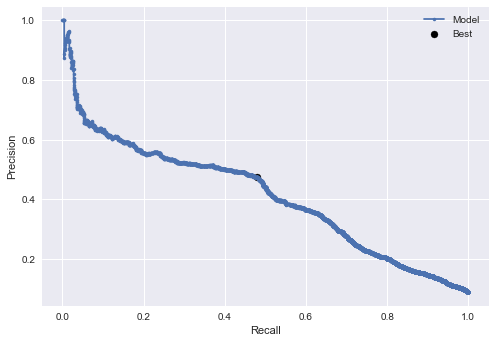

In [70]:
mt.plot_precision_recall_curve()

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


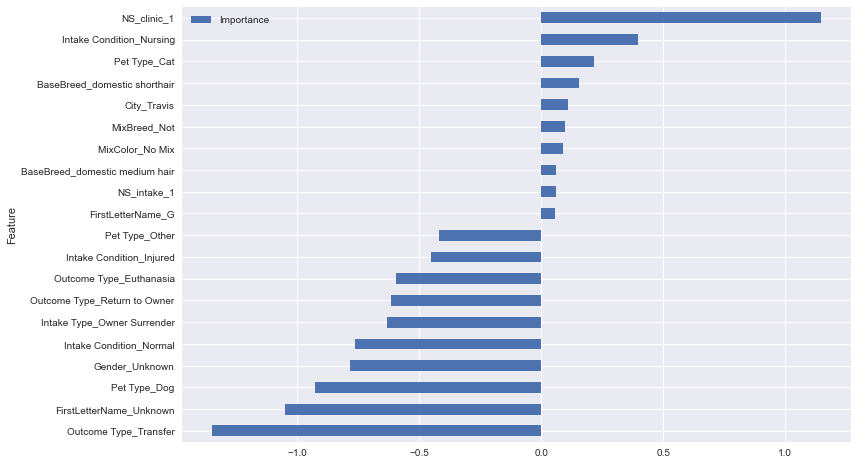

In [71]:
mt.plot_feature_importance()

In [72]:
penalty = ['l2','l1','elasticnet']
c= [.5,.8,1,1.2,1.4]
grid = dict(penalty=penalty,C=c)
mt.optimize_run(grid)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Best: 0.089015 using {'penalty': 'l2', 'C': 1}
Best Threshold=0.280435, F-Score=0.477
precision, recall, threshold, f1score attributes updated
feature_importance attribute updated


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [73]:
mt.log

,Name,ModelType,F1,PR-AUC,OptimalThreshold,LogTime
0,Base_log0,log,0.477841,0.391715,0.273391,2022-02-21 21:39:01.181493
1,xgb0,xgb,0.652681,0.698063,0.320318,2022-02-21 23:13:57.114989
2,xgb1,xgb,0.658920,0.691520,0.308781,2022-02-22 00:07:30.701539
